In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


[[  62.     60.     66.   ...   85.     85.     87.  ]
 [1013.   1013.   1013.   ... 1012.   1013.   1013.  ]
 [   0.      0.      0.   ...    0.      0.      0.  ]
 [   0.      0.      0.   ...   97.      0.      0.  ]
 [  25.46   24.81   23.81 ...   15.81   15.81   16.81]]
{'solutions': [{'spin': {'x[0][0]': 0, 'x[0][1]': 0, 'x[0][2]': 0, 'x[0][3]': 0, 'x[0][4]': 1, 'x[10][0]': 0, 'x[10][1]': 0, 'x[10][2]': 0, 'x[10][3]': 1, 'x[10][4]': 0, 'x[11][0]': 0, 'x[11][1]': 0, 'x[11][2]': 0, 'x[11][3]': 1, 'x[11][4]': 0, 'x[12][0]': 0, 'x[12][1]': 0, 'x[12][2]': 0, 'x[12][3]': 0, 'x[12][4]': 0, 'x[13][0]': 0, 'x[13][1]': 0, 'x[13][2]': 0, 'x[13][3]': 1, 'x[13][4]': 0, 'x[14][0]': 0, 'x[14][1]': 0, 'x[14][2]': 0, 'x[14][3]': 1, 'x[14][4]': 0, 'x[15][0]': 0, 'x[15][1]': 0, 'x[15][2]': 0, 'x[15][3]': 1, 'x[15][4]': 0, 'x[16][0]': 0, 'x[16][1]': 0, 'x[16][2]': 0, 'x[16][3]': 1, 'x[16][4]': 0, 'x[17][0]': 0, 'x[17][1]': 0, 'x[17][2]': 0, 'x[17][3]': 1, 'x[17][4]': 0, 'x[18][0]': 0, 'x[18][1]': 0,

/tmp/ipykernel_5825/1240874690.py:195: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


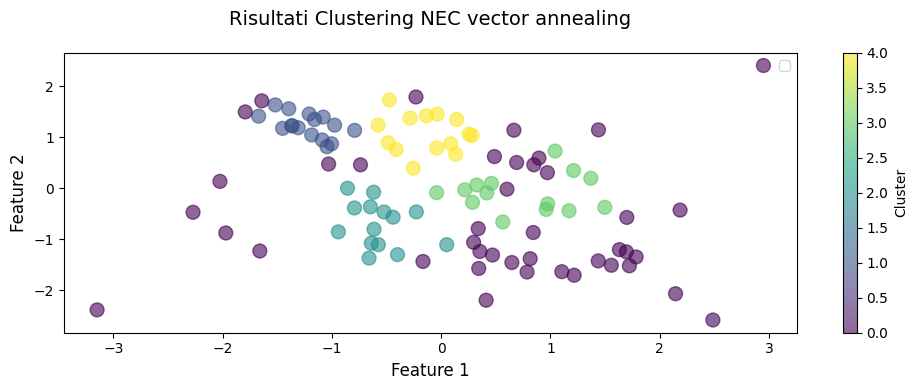

In [4]:
import numpy as np
from pyqubo import Array, Constraint, Binary
from scipy.spatial.distance import pdist, squareform

def create_qubo_clustering(points, n_clusters, distance_weight=1.0, balance_weight=1.0):
    """
    Create a QUBO model for clustering points into specified number of clusters.
    
    Args:
        points (np.ndarray): Array of shape (n_points, n_dimensions)
        n_clusters (int): Number of desired clusters
        distance_weight (float): Weight for distance term in QUBO
        balance_weight (float): Weight for cluster balance constraints
    
    Returns:
        dictionary: (model)
    """
    n_points = len(points)
    
    # Calculate pairwise distances
    distances = squareform(pdist(points))
    
    # Create binary variables x[i][k] indicating if point i is in cluster k
    x = Array.create('x', shape=(n_points, n_clusters), vartype='BINARY')
    
    # Objective: Minimize sum of pairwise distances within clusters
    distance_term = 0
    for i in range(n_points):
        for j in range(i + 1, n_points):
            for k in range(n_clusters):
                distance_term += distances[i][j] * x[i][k] * x[j][k]
    
    # Constraint: Each point must be assigned to exactly one cluster
    point_constraints = 0
    for i in range(n_points):
        point_sum = sum(x[i][k] for k in range(n_clusters))
        point_constraints += Constraint((point_sum - 1)**2, label=f'point_{i}')
    
    # Constraint: Try to balance cluster sizes
    balance_term = 0
    target_size = n_points / n_clusters
    for k in range(n_clusters):
        cluster_size = sum(x[i][k] for i in range(n_points))
        balance_term += (cluster_size - target_size)**2

    # ADD YOUR OWN CONSTRAINTS HERE
    

    
    # Combine terms into final Hamiltonian
    H = (
        distance_weight * distance_term + 
        2.0 * point_constraints + 
        balance_weight * balance_term
    )
    
    model = H.compile()
    return model
    
def decode_solution(n_points, n_clusters, sample):
    """Decode binary solution into cluster assignments."""
    #decoded = model.decode_sample(sample, vartype='BINARY')
    print(n_points,n_clusters,sample)
    assignments = np.zeros(n_points, dtype=int)
        
    # Extract cluster assignments from binary variables
    for i in range(n_points):
        for k in range(n_clusters):
            if sample[f'x[{i}][{k}]'] == 1:
                assignments[i] = k
           
        
    return assignments
    
    

def solve_clustering(points, n_clusters, solver_method='simulated_annealing'):
    """
    Perform clustering using QUBO formulation.
    
    Args:
        points (np.ndarray): Points to cluster
        n_clusters (int): Number of clusters
        solver_method (str): Optimization method to use
    
    Returns:
        np.ndarray: Cluster assignments
    """
    
    model = create_qubo_clustering(points, n_clusters)
    qubo, offset =model.to_qubo()
    
    
    if solver_method == 'simulated_annealing':
        from neal import SimulatedAnnealingSampler
        sampler = SimulatedAnnealingSampler()
        response = sampler.sample_qubo(qubo, num_reads=100)
        result = response.first.sample
        from sklearn.manifold import MDS
        

        

    elif solver_method == 'nec':
        from qbraid import QbraidProvider


        ## INSERT YOU KEY HERE
        provider = QbraidProvider(api_key="")
        device = provider.get_device("nec_vector_annealer")

        params = {
            "offset": offset,
            "num_reads": 10,
        }

        job = device.run(model, params=params)
        sample = job.result()
        print(sample.data.to_dict())
        result =sample.data.to_dict()['solutions'][0]['spin']
        print(sample.data.to_dict()['solutions'])

        
    else:
        raise ValueError(f"Solver method {solver_method} not implemented")
    
    return result


def weather_clustering():
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Read the CSV file
    # Replace 'your_file.csv' with your actual file path
    dfw = pd.read_csv('weather-010824-061024.csv')


    dfw.head
    # Display initial info about NaN values

    # Option 1: Remove rows with any NaN values
    dfw_clean = dfw.dropna()


    # Option 4: Fill NaN values with 0
    dfw_clean = dfw.fillna(0)
    cluster_assignments=[]
    dfw.describe()

    c1=dfw["hum"].to_numpy()
    c2=dfw["pres"].to_numpy()
    c3=dfw["rain_1h"].to_numpy()
    c4=dfw["clouds_all"].to_numpy()
    c5=dfw["max_temp"].to_numpy()
    c6=dfw["min_temp"].to_numpy()
    c7=dfw["wind_speed"].to_numpy()
    #data1 = np.vstack([c1, c2, c3, c4 , c5, c6, c7] )
    data1 = np.vstack([c1, c2, c3, c4 , c6] )
    # Show the plot
    data=data1.T
    print(data1)
    
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    import time
    scaler = StandardScaler()
    
    n_points=100
    data_scaled = scaler.fit_transform(data)[0:n_points]
    
    n_clusters = 5
    
    
    st=time.time()
    random_state = 42
    result_nec = solve_clustering(data_scaled, n_clusters, solver_method='nec') 
    cluster_assignments_nec= decode_solution(n_points, n_clusters,result_nec)
    et=time.time()
    nectime=et-st
    from sklearn.manifold import  MDS
    mds = MDS(n_components=2, random_state=random_state)
    data_2d= mds.fit_transform(data_scaled)  
    # Creazione del plot
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Scatter plot dei punti colorati per cluster
    scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], 
                        c=cluster_assignments_nec, 
                        cmap='viridis',
                        alpha=0.6,
                        s=100)
    # Personalizzazione del plot
    ax.set_title('Risultati Clustering NEC vector annealing', fontsize=14, pad=20)
    ax.set_xlabel('Feature 1', fontsize=12)
    ax.set_ylabel('Feature 2', fontsize=12)
    ax.legend()

  
    
    # Aggiunta della colorbar
    plt.colorbar(scatter, label='Cluster')
    
    plt.tight_layout()
    print(nectime)
    return data_scaled, cluster_assignments,  cluster_assignments_nec


points, clusters, clusters_nec = weather_clustering()


print("Cluster assignments for nec:", clusters_nec)

In [ ]:
# Your goal is to submit a result where the solutions energy is below the above 575

In [ ]:
# Bonus problem, send your solution to Ricky!